# This file generates the prediction plot and Heatmap for the paper

The actual derivation/testing of this model is in exp/exp002_Heatmap

## Data

In [1]:
%matplotlib inline
from tueplots import bundles
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "svg")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update(bundles.neurips2021(usetex=False))
import matplotlib
from datetime import datetime

from helpers import heatmap_colormap, ExpSigModel

In [2]:
data = pd.read_csv("../dat/SimpleCombinedData.csv", parse_dates=["date"])
data.head()

,date,cases,deaths,cases_smoothed,deaths_smoothed,cfr,air temperature
0,2020-01-02,1.0,0.0,0.142857,0.0,0.0,2.820693
1,2020-01-03,0.0,0.0,0.142857,0.0,0.0,2.697867
2,2020-01-04,0.0,0.0,0.142857,0.0,0.0,3.165813
3,2020-01-05,0.0,0.0,0.142857,0.0,0.0,3.853173
4,2020-01-06,0.0,0.0,0.000000,0.0,0.0,4.002133


In [3]:
def features(date, temp):
    return np.stack(
    (
        date,
        temp,
    ), axis=1
)

In [4]:
X = features(data.index, data["air temperature"])
y = data.cfr.to_numpy()

peak_of_first_wave = np.argmax(y) # see exp001

## Heatmap

In [5]:
time = np.unique(data.date.apply(lambda x: f"{x.year}-{x.month:02d}"))
temp = np.arange(
    data["air temperature"].round().min(),
    data["air temperature"].round().max() + 1
)[::-1]

print(time.shape, temp.shape)

(25,) (35,)


Generate ground truths heatmap by looping over the dataset and making lists of temperatures seen every month, then compute the average. Also make an alpha_map indicating where there are no values

In [6]:
heatmap = [[ [] for _ in time] for _ in temp]
heatmap_alpha = [[ [] for _ in time] for _ in temp]

for t, at, cfr in zip(data.date, data["air temperature"], data.cfr):
    
    date = f"{t.year}-{t.month:02d}"
    j = np.argwhere(time == date)[0,0]
    
    air_temp = np.round(at)
    i = np.argwhere(temp == air_temp)[0,0]
    
    heatmap[i][j].append(cfr)
    
for i in range(len(heatmap)):
    for j in range(len(heatmap[0])):
        if len(heatmap[i][j]) == 0:
            heatmap[i][j] = 0
            heatmap_alpha[i][j] = 0
        else:
            heatmap[i][j] = np.array(heatmap[i][j]).mean()
            heatmap_alpha[i][j] = 1

heatmap = np.array(heatmap)
heatmap_alpha = np.array(heatmap_alpha, dtype=np.float64)

## Plotting

In [7]:
model = ExpSigModel(startvalue=peak_of_first_wave)
model.fit(X, y)

 final_simplex: (array([[ 0.26349449, -0.00549297, -0.15731279, -3.4041077 ],
       [ 0.26349485, -0.00549296, -0.15731217, -3.40404568],
       [ 0.26349318, -0.00549296, -0.15731252, -3.40412113],
       [ 0.26349284, -0.00549296, -0.1573127 , -3.40414778],
       [ 0.26349447, -0.00549297, -0.15731277, -3.40411923]]), array([0.03144304, 0.03144304, 0.03144304, 0.03144304, 0.03144304]))
           fun: 0.03144304281448605
       message: 'Optimization terminated successfully.'
          nfev: 246
           nit: 143
        status: 0
       success: True
             x: array([ 0.26349449, -0.00549297, -0.15731279, -3.4041077 ])


In [8]:
print(model.evaluate(X[peak_of_first_wave:], y[peak_of_first_wave:]))

0.03144304281448605


In [9]:
SMOOTHING_TIMEFRAME_DAYS = 14

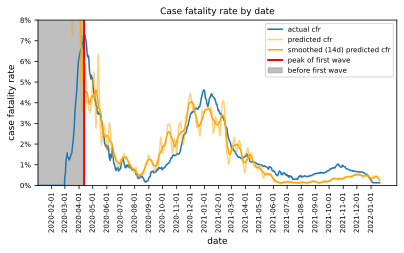

In [10]:
#plt.figure(figsize=(6,4))
plt.plot(y, label="actual cfr")
y_pred = model(X)
plt.plot(y_pred, label="predicted cfr", alpha=0.5, color="orange")

y_pred_smooth = np.convolve(y_pred, np.ones(SMOOTHING_TIMEFRAME_DAYS), "same") / SMOOTHING_TIMEFRAME_DAYS
plt.plot(y_pred_smooth, label=f"smoothed ({SMOOTHING_TIMEFRAME_DAYS}d) predicted cfr", color="orange")

plt.axvline(peak_of_first_wave, label="peak of first wave", color="red", linewidth=2)
plt.fill(
    [0, 0, peak_of_first_wave, peak_of_first_wave],
    [0, 0.8, 0.8, 0],
    color="grey",
    alpha=0.5,
    label="before first wave"
)


plt.ylim([0, 0.08])
plt.xlim(0)
months = data.date[data.date.apply(lambda x: x.day == 1)]
plt.xticks(months.index, months.apply(lambda x: f"{x.year}-{x.month:02d}-{x.day:02d}"), rotation=90)
yticks = plt.yticks()[0]
plt.yticks(yticks, [f"{float(ytick):2.0%}" for ytick in yticks])

plt.xlabel("date")
plt.ylabel("case fatality rate")
plt.legend()

plt.savefig("../fig/prediction.pdf")
plt.title("Case fatality rate by date")
plt.show()

In [11]:
months_as_days_since_outbreak = data.date[data.date.apply(lambda x: x.day) == 15]
days = months_as_days_since_outbreak.index
days_grid, temp_grid = np.meshgrid(days, temp)

In [12]:
X_pred = features(days_grid.flatten(), temp_grid.flatten())
y_pred = model(X_pred)

In [13]:
prediction = y_pred.reshape(heatmap.shape)

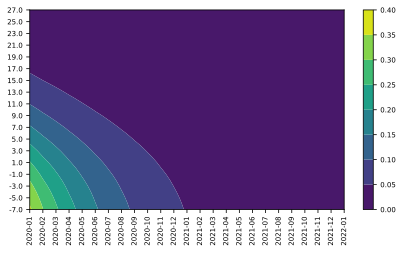

In [14]:
plt.contourf(prediction[::-1])
plt.xticks(np.arange(len(time)), time, rotation=90)
plt.yticks(np.arange(len(temp))[::2], temp[::-2])
plt.colorbar()
plt.show()

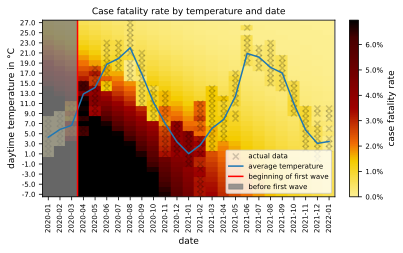

In [15]:
#plt.figure(figsize=(10,5))
vmin = heatmap.min()
vmax = heatmap.max()
plt.imshow(prediction, vmin=vmin, vmax=vmax, aspect="auto", cmap=heatmap_colormap)
hm = plt.imshow(heatmap, vmin=vmin, vmax=vmax, aspect="auto", cmap=heatmap_colormap, alpha=heatmap_alpha)

a, b = np.where(heatmap_alpha == 1)
plt.scatter(b, a, marker="x", color="black", alpha=0.18, label="actual data")

plt.xticks(np.arange(len(time)), time, rotation=90)
plt.yticks(np.arange(len(temp))[::2], temp[::2])
beginning = 2.5
plt.plot(
    temp.max() - 
    data["air temperature"]
        .groupby(lambda x: f"{data.iloc[x].date.year}-{data.iloc[x].date.month:02d}")
        .mean(),
    label="average temperature"
)
plt.axvline(beginning, color="red", label="beginning of first wave")
plt.fill(
    [-1, -1, beginning, beginning],
    [-0.5, heatmap.shape[0]-0.5, heatmap.shape[0]-0.5, -0.5],
    color="grey",
    alpha = 0.8,
    label="before first wave"
)
plt.colorbar(hm, format=matplotlib.ticker.PercentFormatter(xmax=1), label="case fatality rate", alpha=1)
plt.legend(loc="lower right")
plt.xlabel("date")
plt.xlim(-0.5)
plt.ylabel("daytime temperature in °C")
plt.savefig("../fig/heatmap.pdf")
plt.title("Case fatality rate by temperature and date")
plt.show()

In [16]:
print(model.to_latex())

0.2635 \cdot e^{ \frac{-0.0055}{d} \cdot (t - 101d) } \cdot  \sigma \left(\frac{-0.157}{^\circ C} \cdot (\theta  -3.40^\circ C) \right) \cdot \frac{deaths}{cases}


Final formula
$$
0.2635 \cdot e^{ \frac{-0.0055}{d} \cdot (t - 101d) } \cdot  \sigma \left(\frac{-0.157}{^\circ C} \cdot (\theta  -3.40^\circ C) \right) \cdot \frac{deaths}{cases}
$$

In [17]:
with open("../doc/formula.tex", "w") as f:
    f.write(model.to_latex())